# Prediction of Involvement of Drunk Drivers in Fatal Highway Crashes
## Inferential Statistics and Data Storytelling

### Chester Hitz | Springboard Data Science Career Track | Capstone II

This notebook represents work for my second capstone, following a pivot after my initial question proved unanswerable with my dataset (see: [Data Wrangling](), [EDA]()). In that initial question, I sought to predict the rate of accidents (accidents per 100k vehicles) on 72k one-kilometer segments of the US interstate system, using characteristics of the roads themselves. What I found was no significant correlation between the road characteristics and the accident rate. In fact, a linear regressor trained on the data produced an RMSE virtually identical to a dummy matrix full of zeros.

In response, I have decided to use the same data to pivot my capstone towards predicting charactertistics of the crashes themselves using the FARS dataset. The factor I will try to predict is **whether or not at least one of the vehicles involved in the fatal collision had a drunk driver**. 

There is a massive number of information contained as features for each accident and it is easier in this case to extract useful information from the dataset rather than pare off useless info. In this case, I am instead going to focus on:
* Timing: Time of day and day of week.
* Crash events: Contained within the five PCRASH variables is a sequence of 5 steps that happen in every crash, with each step describing a different event. More description in section.
* Various other factors: Involvement of speeding and road type.

### The Data

The data being used here comes from the Fatality Analysis Reporting System (FARS), which I used in the previous version of my capstone to map out different highway segments. It covers every fatal road accident in the United States in the years I have selected, 2010-2014. I also have used QGIS to join the various characteristics (speed limit, curviness of road, presence of median on the road) of the road segments the crashes occured on to the data. To my knowledge, this has not been tried in the past and I hope will lead to better predictions of my target variable.

The first step is to import necessary libraries and load in the data:

In [1]:
import numpy as np
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

init_notebook_mode(connected=True)

df = pd.DataFrame()
for year in ['2010','2011','2012','2013','2014']:
    year_df = pd.read_csv(str('FARS zips/' + year + '_accident.csv'), low_memory=False)
    vehicle_df = pd.read_csv('FARS zips/' + year + '_vehicle.csv', low_memory=False)
    print(year,':',len(year_df))
    year_df = year_df.merge(vehicle_df, on='ST_CASE', suffixes=('', '_y'))
    df = pd.concat([df, year_df])

print(df.shape)
print(df.info())

2010 : 30296
2011 : 29867
2012 : 31006
2013 : 30202
2014 : 30056
(224992, 176)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 224992 entries, 0 to 44949
Columns: 176 entries, ACC_TYPE to YEAR
dtypes: float64(19), int64(128), object(29)
memory usage: 303.8+ MB
None


In [2]:
df.head(5)

,ACC_TYPE,ARR_HOUR,ARR_MIN,BODY_TYP,BUS_USE,CARBUR,CARGO_BT,CDL_STAT,CF1,CF2,...,V_CONFIG,WEATHER,WEATHER1,WEATHER2,WGTCD_TR,WHLBS_LG,WHLBS_SH,WHLDRWHL,WRK_ZONE,YEAR
0,1,4,20,15,0,NaN,0,0,0,0,...,0,1,1,0,1.000000e+16,0.000000e+00,1.191000e+03,NaN,0,2010
1,6,6,9,4,0,NaN,0,0,0,0,...,0,1,1,0,1.000000e+16,0.000000e+00,1.080000e+03,NaN,0,2010
2,69,15,16,80,0,NaN,0,0,0,0,...,0,1,1,0,1.000000e+16,1.000000e+16,1.000000e+16,NaN,0,2010
3,68,15,16,4,0,NaN,0,0,0,0,...,0,1,1,0,1.000000e+16,0.000000e+00,1.093000e+03,NaN,0,2010
4,98,15,16,4,0,NaN,0,0,0,0,...,0,1,1,0,1.000000e+16,0.000000e+00,1.102000e+03,NaN,0,2010


As we can see from the shape attribute, there are a lot of column in the dataframe - 159 in all.



## Exploratory Data Analysis
The first questions are: How many fatal crashes occured, and how many of them involved a drunk driver?

In [4]:
df.DRUNK_DR.value_counts()

0    161198
1     60797
2      2858
3       112
4        27
Name: DRUNK_DR, dtype: int64

Of the 40,237 crashes that occured, 29,291 of them did not have a drunk driver and 10,455 had at least one drunk driver, with 481 of those having two drunk drivers and, somehow, 27 of them involved *four* drunk drivers. Since the question here is whether or not a drunk driver was involved in the crash, I'm going to quickly transform our target variable to a boolean variable DRUNK_INV.

In [5]:
df['DRUNK_INV'] = df['DRUNK_DR'] > 0

# and a quick check
print(df[['DRUNK_INV','DRUNK_DR']].tail())

       DRUNK_INV  DRUNK_DR
44945       True         1
44946      False         0
44947       True         1
44948      False         0
44949       True         1


### Preliminary Data Cleaning

While the data coming in from the FARS database is largely already cleaned, there are still a lot of unnecessary features attached to the data. More detailed descriptions of the various features can be found in the [FARS Analytical User’s Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812447), but rough summaries are given below as various features irrelevant to the target data are dropped.

In [22]:
# drops duplicate columns
for x in df.columns:
    if '_y' in x: df.drop(x, axis=1, inplace=True)

# this is not efficient code, but I am organizing it like this to better show my thinking.
target = ['DRUNK_INV']

# timing conditions: hour of day, day of the week, light conditions
timing = ['HOUR','DAY_WEEK','LGT_COND']

# the events in the crash
crash_events = ['CF1','CF2','CF3','P_CRASH1','P_CRASH2','P_CRASH3','PCRASH4','PCRASH5']

# Various other factors: Vehicle speed, speed limit, route, and total number of fatalities.
others = ['VSPD_LIM','TRAV_SP','FATALS','ROUTE']

df = df[target + timing + crash_events + others]
df = df.reset_index()

Of those factors selected, we can do a quick test for correlation keeping in mind many of the factors will not be neatly linearly correlated due to their categorical nature.

In [23]:
df.corr()['DRUNK_INV']

index       -0.009332
DRUNK_INV    1.000000
HOUR        -0.028328
DAY_WEEK     0.020281
LGT_COND     0.203954
CF1         -0.010622
CF2         -0.007704
CF3          0.000839
P_CRASH1     0.040560
P_CRASH2    -0.181923
P_CRASH3     0.002418
PCRASH4      0.052724
PCRASH5      0.176708
VSPD_LIM    -0.045501
TRAV_SP      0.178911
FATALS       0.031176
ROUTE        0.056413
Name: DRUNK_INV, dtype: float64

----------------------------------------------
### Time

The first set of factors to look at are the time variables. The HOUR variable is naturally set to a normal 24-hour clock, but that does not naturally align with our conceptions of night and day since midnight resets everything. If we apply the function below to the HOUR series, it transforms the hour series into HOURS since 5am, or dawn in most regions. This is a more accurate reflection of societal rhythms. This is best illustrated with two bar plots, one for the regular 24 hr clock and the other for time since 5AM.

In [9]:
drunk_data = [dict(Counter([  int(n) for n in df[df.DRUNK_INV == True  ].HOUR if n >= 0  ])).get(x) for x in range(0,25)]
sober_data = [dict(Counter([  int(n) for n in df[df.DRUNK_INV == False].HOUR if n >= 0  ] )).get(x) for x in range(0,25)]

drunk = go.Bar(
    x=[str(x)+':00' for x in list(range(1,24))],
    y= drunk_data,
    name='Drunk',
    textposition = 'auto',
    marker=dict(color='#c14b22')
)

sober = go.Bar(
    x=[str(x)+':00' for x in list(range(1,24))],
    y= sober_data,
    name='Sober',
    marker=dict(color='#106f7c')
)

data = [sober, drunk]
layout = go.Layout(
    barmode='stack',
    title='Drunk Driver Involved Accidents Per Hour of Day',
    yaxis=dict(title='Crashes'),
    xaxis=dict(title='Hour of Day')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

In [10]:
def time_set(x):
    if x >= 7:
        return x-7
    else:
        return x+17
df.loc[:,'corrected_HOUR'] = df.loc[:,'HOUR'].apply(time_set)

In [11]:
drunk_data = [dict(Counter([  int(n) for n in df[df.DRUNK_INV == True].corrected_HOUR if n >= 0  ])).get(x) for x in range(0,25)]
sober_data = [dict(Counter([  int(n) for n in df[df.DRUNK_INV == False].corrected_HOUR if n >= 0  ] )).get(x) for x in range(0,25)]

drunk = go.Bar(
    x=list(range(1,24)),
    y= drunk_data,
    name='Drunk',
    textposition = 'auto',
    marker=dict(color='#c14b22')
)

sober = go.Bar(
    x=list(range(1,24)),
    y= sober_data,
    name='Sober',
    marker=dict(color='#106f7c')
)

data = [sober, drunk]
layout = go.Layout(
    barmode='stack',
    title='Drunk Driver Involved Accidents Per Hour (Since 7AM)',
    yaxis=dict(title='Crashes'),
    xaxis=dict(title='Hours since 7AM')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

As we can see from the second chart, trying to understand the role time of day plays in drunk driving accidents makes more sense if we set the start of the day at 7AM.

The second factor to consider is day of the week. As one might suspect, more drunk driving accidents, and accidents overall, take happen on the weekends. This is visualized below: 

In [12]:
drunk_data = [dict(Counter([  int(n) for n in df[df.DRUNK_INV == True  ].DAY_WEEK if n >= 0  ])).get(x) for x in range(1,8)]
sober_data = [dict(Counter([  int(n) for n in df[df.DRUNK_INV == False].DAY_WEEK if n >= 0  ] )).get(x) for x in range(1,8)]

days = ['Mon','Tues','Weds','Thurs','Fri','Sat','Sun']

drunk = go.Bar(
    x=days,
    y= drunk_data,
    name='Drunk',
    textposition = 'auto',
    marker=dict(color='#c14b22')
)

sober = go.Bar(
    x=days,
    y= sober_data,
    name='Sober',
    marker=dict(color='#106f7c')
)

data = [sober, drunk]
layout = go.Layout(
    barmode='stack',
    title='Drunk Driver Involved Accidents Per Day of Week',
    yaxis=dict(title='Crashes'),
    xaxis=dict(title='Day of Week')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

Like time, we impose an arbitary start point for the week at 12AM on Sunday. Given what we know about drinking on the weekends, it makes more sense to create a binary for True if the crash occured on a Friday, Saturday or Sunday, and False if it occured outside of that. This feature is called "Weekend".

In [13]:
def is_weekend(x):
    if x in [1,6,7]: return True
    else: return False
    
df.loc[:,'Weekend'] = df.loc[:,'DAY_WEEK'].apply(time_set)

We can then verify the utility of the previous transformations by testing the correlation against DRUNK_INV, along with the original factors. As we can see below, the factors are significantly more correlated after transformation.

In [14]:
df.corr().loc[['HOUR','corrected_HOUR','DAY_WEEK','Weekend'],'DRUNK_INV']

HOUR             -0.028328
corrected_HOUR    0.249686
DAY_WEEK          0.020281
Weekend          -0.116570
Name: DRUNK_INV, dtype: float64

-----------------------------------------------------
### Precrash Movement

Precrash movement are a very interesting set of variables that essentially tell a story of a crash through categorical variables. 
* P_CRASH1:  identifies the attribute that best describes this vehicle's activity prior to the driver's realization of an impending critical event or just prior to impact if the driver took no action or had no time to attempt any evasive maneuvers
* P_CRASH2: identifies the attribute that best describes the critical event which made this crash imminent.
* P_CRASH3: identifies the attribute that best describes the movements/actions taken by this driver, within a critical crash envelope, in response to the “Critical Precrash Event.”
* PCRASH4:  identifies the attribute that best describes the stability of this vehicle after the “Critical Precrash Event,” but before the impact
* PCRASH5: identifies the attribute that best describes the location of this vehicle after the “Critical Precrash Event,” but before the impact.

Using the Analysis Manual, we can understand the events from these numbers and steps. For example, the variabes at index [0] describes the following: (1) Driver going straight, (2) Go off the edge of the road on the right side, (3) No Avoidance Manuever, (4) Tracking, (5) Departed Roadway. As there is only one death associated with this crash, that corroborates.

In [15]:
df[['P_CRASH1','P_CRASH2','P_CRASH3','PCRASH4','PCRASH5', 'FATALS']].head(3)

,P_CRASH1,P_CRASH2,P_CRASH3,PCRASH4,PCRASH5,FATALS
0,1,13,1,1,4,1
1,1,12,1,1,4,1
2,1,64,3,2,1,1


For another example, we can look at an accident involving four fatalities (252 in index). In this case, (1) the driver was changing lanes (2) When they were traveling too fast for the road conditions (3) Did not make an avoidance manuever, and (4) skidded laterally in the counterclockwise direction (5) before returning to the roadway.

In [16]:
df.query('FATALS == 4').filter(like='CRASH', axis = 1).head(3)

,P_CRASH1,P_CRASH2,P_CRASH3,PCRASH4,PCRASH5
252,15,6,1,4,6
253,1,64,1,1,1
415,1,52,6,1,6


It is a little difficult to make much sense of these variables and how they relate to the liklihood of one driver being drunk while they are still in categorical, non-ordinal form like this. In the machine learning portion I will use the One Hot Encoder method to turn these event sequences into sparse matrices that will be more machine-readable.

What we can do at this time is take a look at what *initial* movements drunk drivers undertake at a rate higher than other drivers.

In [17]:
pc1_df = pd.read_csv('PC1.csv')
pc1_dict = dict(zip(pc1_df.iloc[:,0],pc1_df.iloc[:,1]))

pc1_ptable = df.pivot_table(index='P_CRASH1', columns='DRUNK_INV', values='FATALS', aggfunc='count')
pc1_ptable['Percent_Drunk'] = (pc1_ptable[True] / (pc1_ptable[True] + pc1_ptable[False]))*100
pc1_ptable['Initial_Move'] = pc1_ptable.index
pc1_ptable['Initial_Move'] = pc1_ptable['Initial_Move'].map(pc1_dict)
pc1_ptable.sort_values('Percent_Drunk', inplace=True, ascending=False)
pc1_ptable

DRUNK_INV,False,True,Percent_Drunk,Initial_Move
P_CRASH1,,,,
14,25690,18403,41.736784,Negotiating a Curve
6,2694,1344,33.283804,Passing or Overtaking Another Vehicle
98,506,212,29.526462,Other
15,2559,957,27.218430,Changing Lanes
3,455,170,27.200000,Accelerating in Traffic Lane or Road
16,301,111,26.941748,Merging
7,183,67,26.800000,Disabled or Parked in Travel Lane
1,102829,36855,26.384554,Going Straight
99,1261,350,21.725636,Unknown


What we can observe here is that impaired drivers most often get into trouble around curves, passing, accelerating, or overtaking other drivers. This is obviously important information, but further insights will be generated with sci-kit learn.

### Other Factors
#### Speed and Route Type

While there are literally hundreds of different factors in the FARS dataset, I am going to use only a few of them beyond the ones already discussed.

The first of those is speed, specifically the relation between the speed of the vehicle and the posted speed limit on that section of road. By subtracting the former from the latter, we can get a new variable with the speed the vehicle was traveling above (or below) the speed limit. 

This new variable is then visualized with a violin plot, where the split is between drunk-driver involved and non-drunk-driver involved accidents. We can see that while the difference is not striking, impaired drivers do tend to speed more than non-impaired drivers as the right side of the "violins" is thicker above zero on all types of roads represented on the x-axis.

In [33]:
# Replacing Unknown value placeholders with NaN values
df['TRAV_SP'] = df['TRAV_SP'].replace([999,998,0], np.nan).replace(997,150)
df['VSPD_LIM'] = df['VSPD_LIM'].replace([99,98,0], np.nan)

# Creating the OverSpeedLimit variable
df.loc[:,'OverSpeedLimit'] = df.loc[:,'TRAV_SP'] - df.loc[:,'VSPD_LIM']

# Mapping out the road types
df['road_type'] = df['ROUTE'].map(
            {1:'Interstate',
             2:'U.S. Highway',
             3:'State Highway',
             4:'County Road',
             5:'Local Street – Township',
             6:'Local Street – Municipality',
             7:'Local Street – Frontage Road',
             8:'Other',
             9:'Unknown'
            }).astype('category')

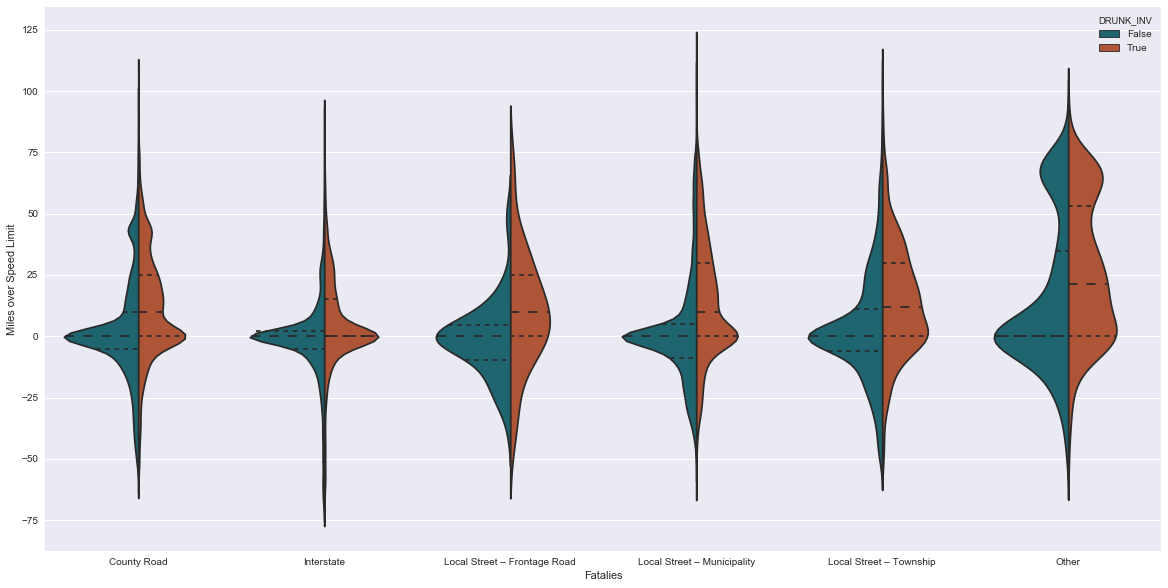

In [34]:
sns.set(style="darkgrid", color_codes=True)

fig, ax = plt.subplots(figsize=(20,10))

g= sns.violinplot(x="road_type", y="OverSpeedLimit", hue="DRUNK_INV", data=df, 
               palette={True: "#c14b22", False: "#106f7c"}, split=True, inner="quart", ax=ax)
g.set(xlim=(-.5, 5.5), xlabel='Fatalies', ylabel='Miles over Speed Limit')
plt.show()

Looking at every instance of the x axis, we can see the spread of drivers going above the speed limit (above 0 on the y-axis) is much thicker for drunk drivers than sober drivers. We can also see this in the correlation between 'OverSpeedLimit' and our target variable.

In [20]:
df.corr()['DRUNK_INV']['OverSpeedLimit']

0.21719050542620988

As for the ROUTE variable itself, it concerns the type of road the accident occured on. It is a categorical variable, but the data is ordinal. As the representative integers increase, the width and use of the road descreases (e.g. Interstates are 1, Local Roads are 8). With this in mind, there is not much correlation between the route type and the frequency of drunk driving accidents.

In [24]:
df.corr()['DRUNK_INV'][['ROUTE']]

ROUTE    0.056413
Name: DRUNK_INV, dtype: float64

In [38]:
route_table = df.pivot_table(index='road_type', columns='DRUNK_INV', values='FATALS', aggfunc='count')
route_table['Percent_Drunk'] = (route_table[True] / (route_table[True] + route_table[False]))*100
route_table.sort_values('Percent_Drunk', inplace=True)
route_table

DRUNK_INV,False,True,Percent_Drunk
road_type,,,
U.S. Highway,29979,9210,23.501493
Interstate,21348,7092,24.936709
State Highway,49954,18264,26.772992
Local Street – Municipality,25644,10499,29.048502
Unknown,514,232,31.099196
Other,5441,2561,32.004499
Local Street – Frontage Road,919,436,32.177122
Local Street – Township,6177,3349,35.156414
County Road,21222,12151,36.409672


The percentage of accidents involving alcohol ranges from 23% for US Highways to 36% for County Road. This can partially be explained by the context of the data - namely that while interstates have more traffic, they are also wider and have more safety features, creating less hazards for drunk drivers. County roads are narrower and less safe by design, but have less traffic. 

It is hard to say whether this variable contains useful information, but it is probably worth expanding it into a matrix using the OHE method in the machine learning section.

## Conclusions

The FARS dataset is massive, both in length and width. Doing a full-level EDA of all the factors available for analysis would take weeks beyond the scope of this project. By selecting just a few factors, we have lready pulled some powerful insights from the data, and we can say the following about the ocurrence of drunk driving accidents in the United States:

* more likely in the late evening and early morning hours.
* more likely on the weekends.
* more likely when the impaired driver is negotiating a curve or attempting maneuvers with other vehicles (merging, passing etc).
* more likely when the driver is speeding above the posted speed limit.
* possibly more likely on county roads.

I am very excited to see what scikit-learn can do with this data in the next step!